#**install and import**

In [ ]:
!pip install -q kaggle
!pip install -q optuna
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
import os
from google.colab import userdata


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_API_KEY')

kaggle_json = {
    "username": kaggle_username,
    "key": kaggle_key
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [ ]:
!kaggle competitions download -c cpe342-karena

 96% 882M/922M [00:07<00:00, 83.4MB/s]
100% 922M/922M [00:07<00:00, 130MB/s] 


In [ ]:
!unzip -q /content/cpe342-karena.zip

In [ ]:
df = pd.read_csv("/content/public_dataset/task1/train.csv")
dftest = pd.read_csv("/content/public_dataset/task1/test.csv")

In [ ]:
df.isnull().sum()

,0
id,0
player_id,0
kill_death_ratio,0
headshot_percentage,0
win_rate,0
accuracy_score,0
kill_consistency,0
reaction_time_ms,0
account_age_days,0
level,0


# Dataset explore

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
print(df.drop(columns=['id', 'player_id'], errors='ignore').groupby('is_cheater').agg(['mean', 'min', 'max', 'median'], numeric_only=True))

           kill_death_ratio                           headshot_percentage  \
                       mean       min   max    median                mean   
is_cheater                                                                  
0.0                4.874901  0.500000  12.0  4.698747           49.236796   
1.0                4.462171  0.600572  12.0  4.316985           45.319631   

                                   win_rate                               \
            min   max     median       mean        min    max     median   
is_cheater                                                                 
0.0         5.0  95.0  48.507512  72.106148  19.072048  100.0  71.995422   
1.0         5.0  95.0  44.648332  70.083655  23.230667  100.0  70.004852   

           accuracy_score                      kill_consistency              \
                     mean  min   max    median             mean   min   max   
is_cheater                                                                 

/tmp/ipython-input-2135280927.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(column=col, by='is_cheater', ax=plt.gca())


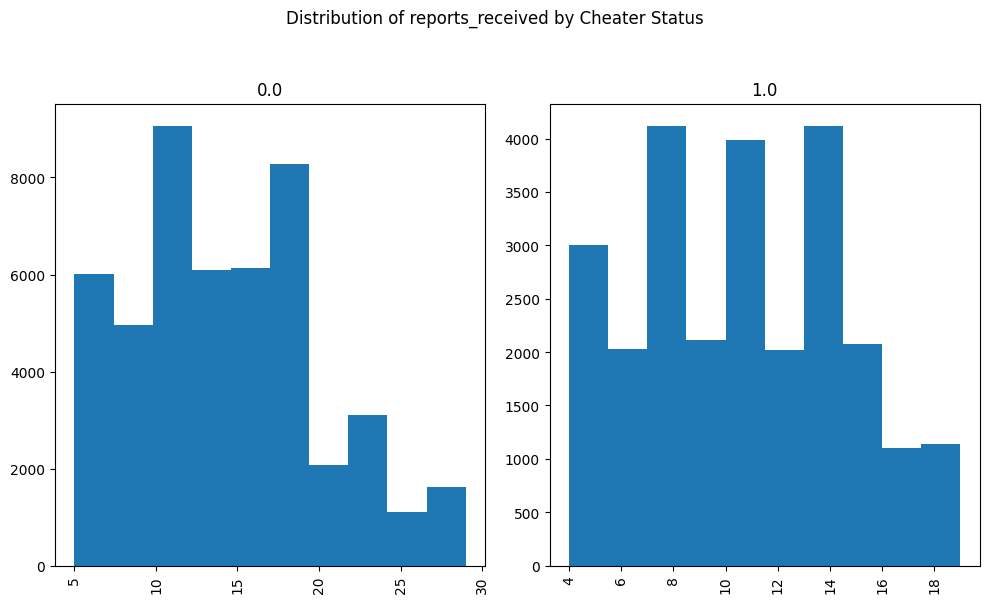

heww


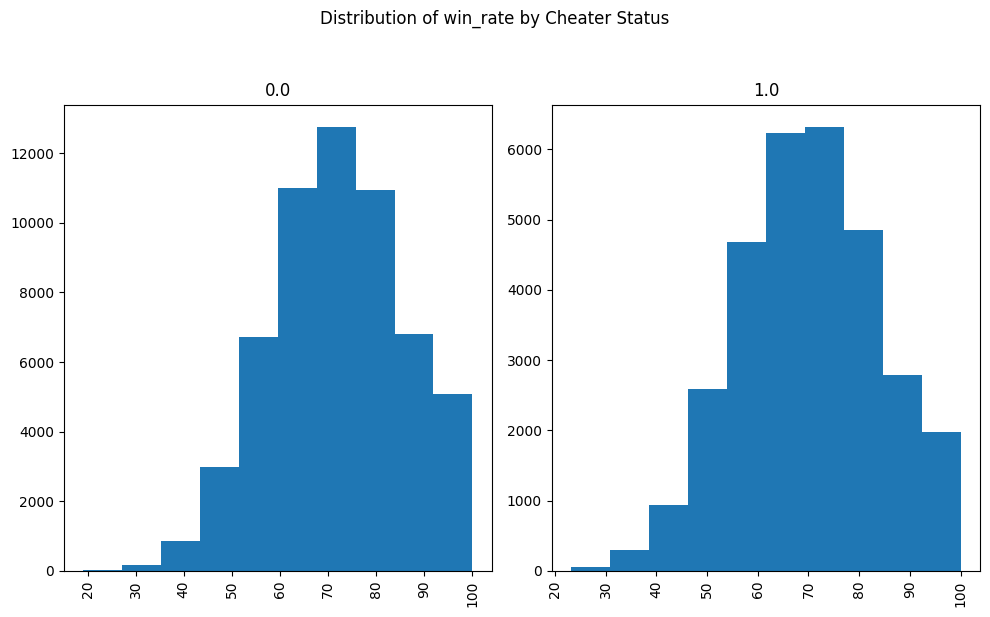

heww


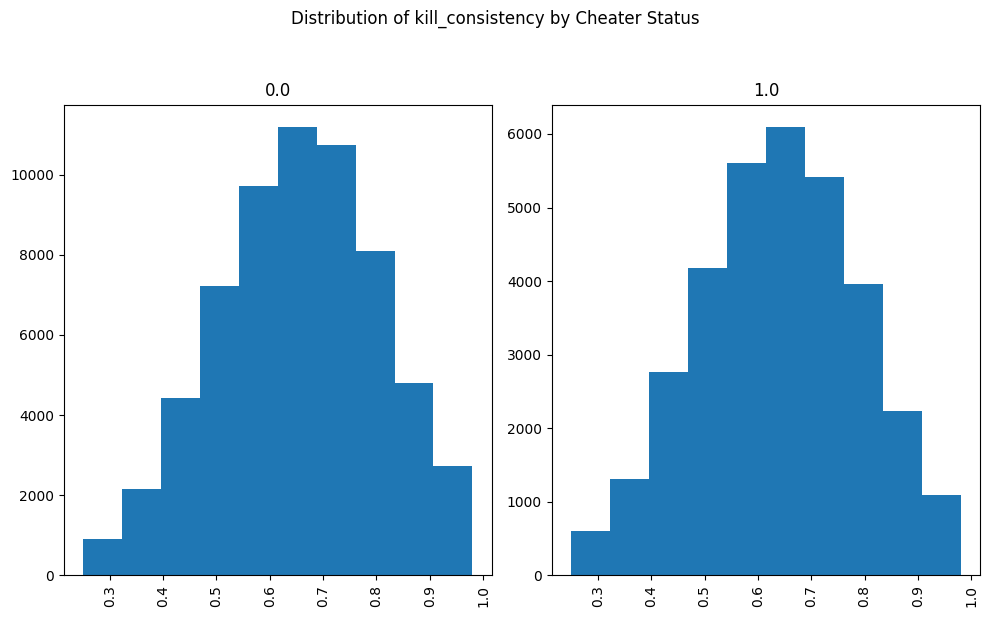

heww


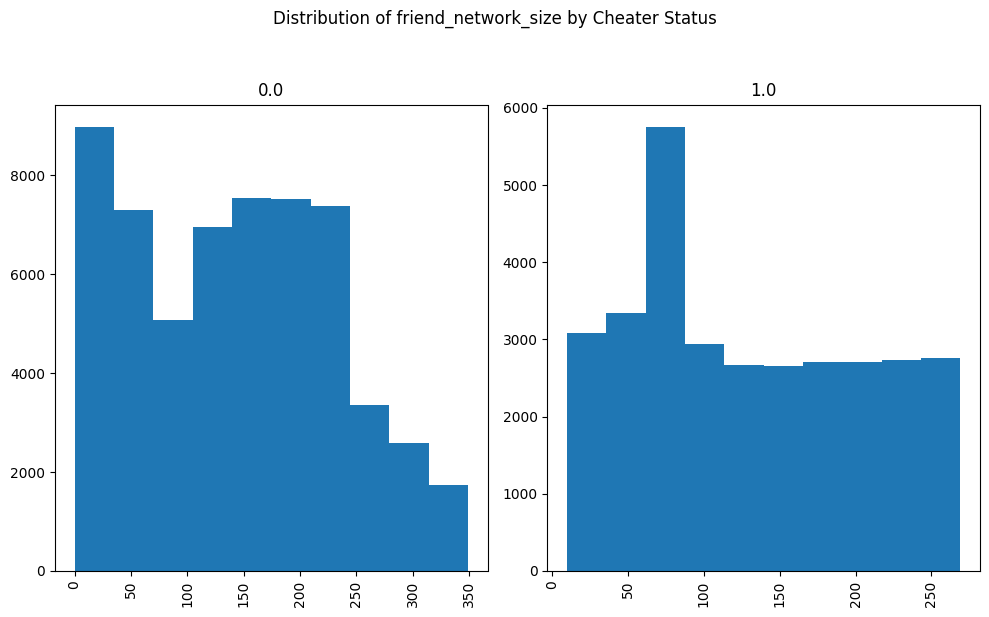

heww


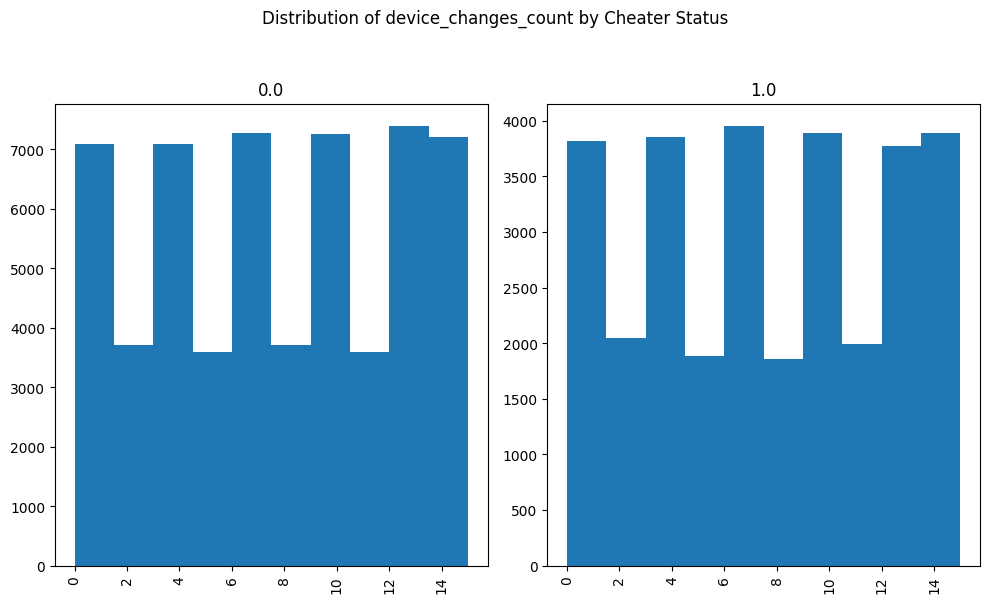

heww


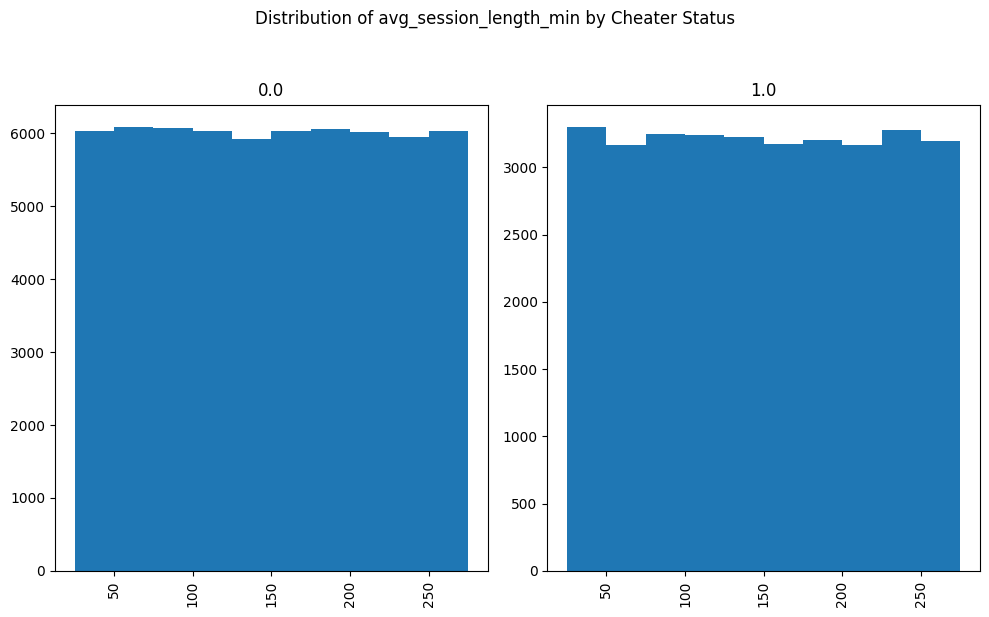

heww


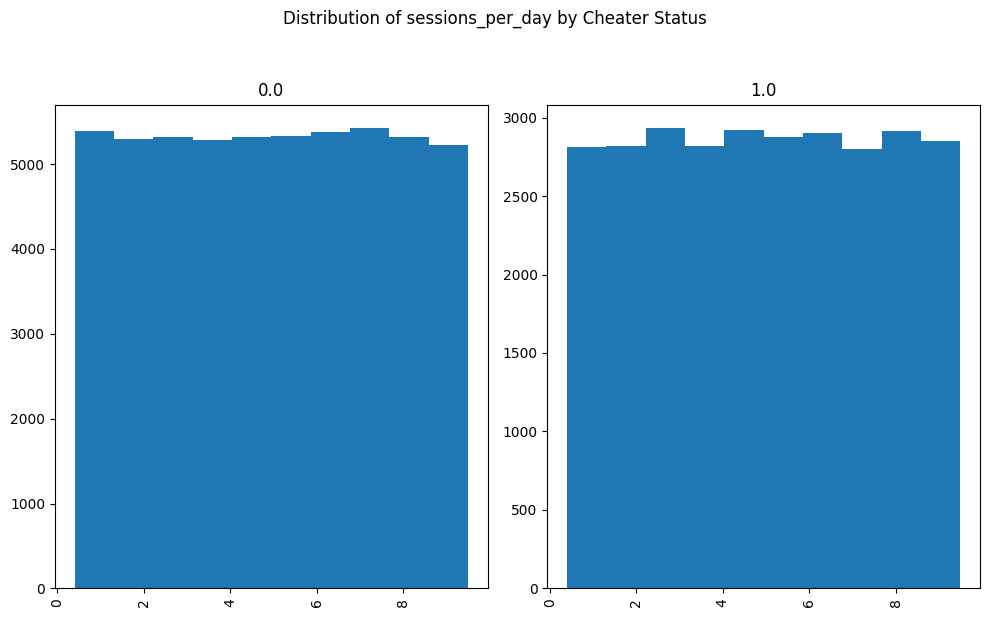

heww


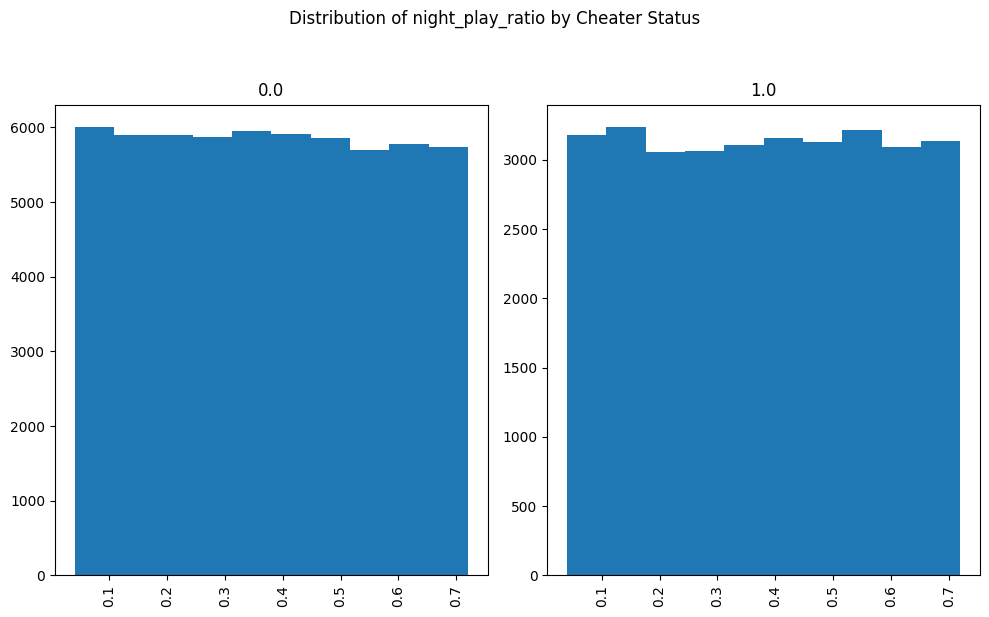

heww


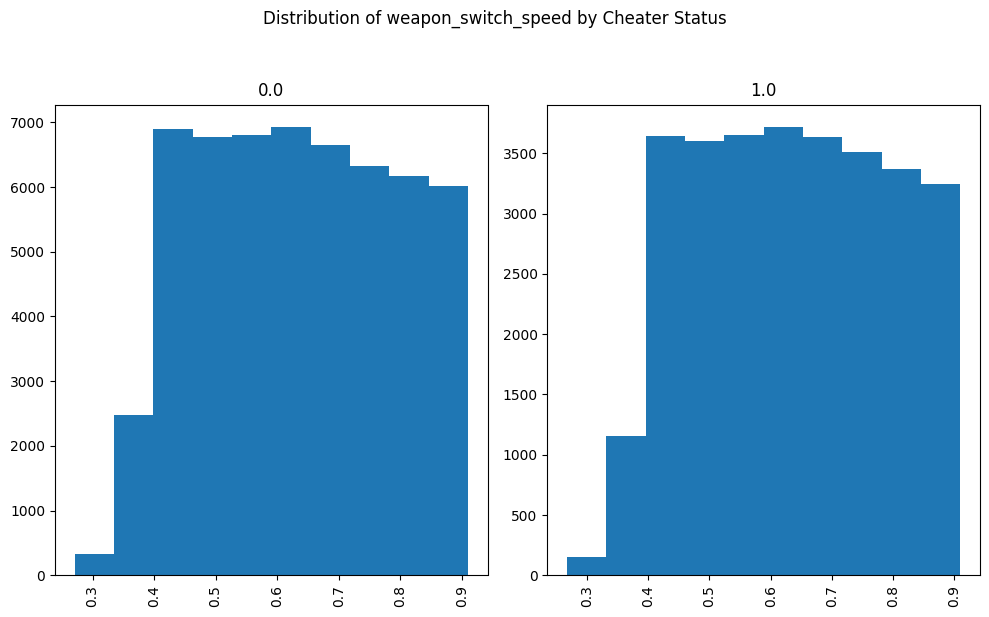

heww


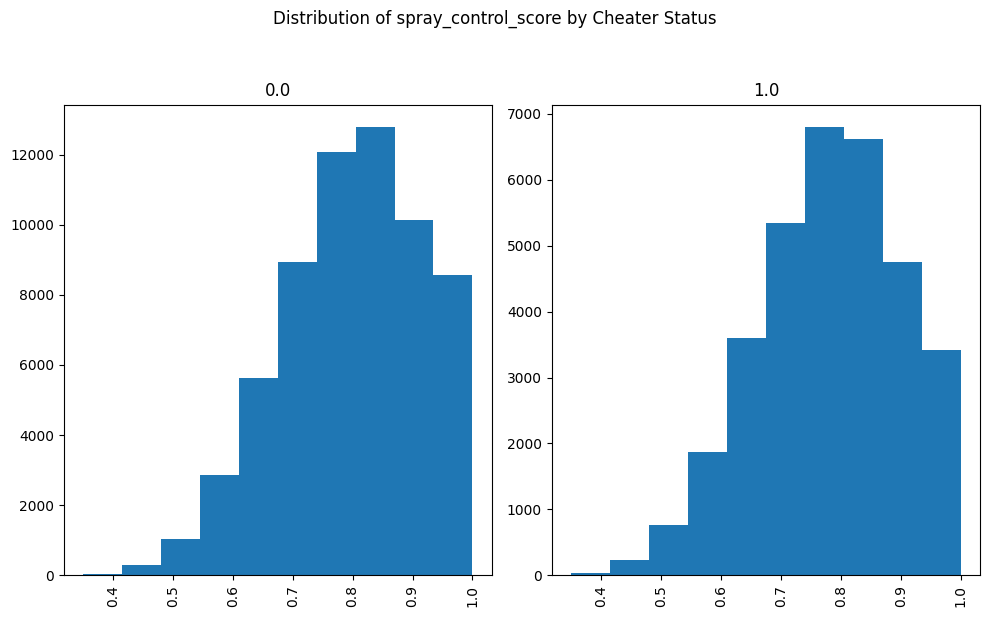

heww


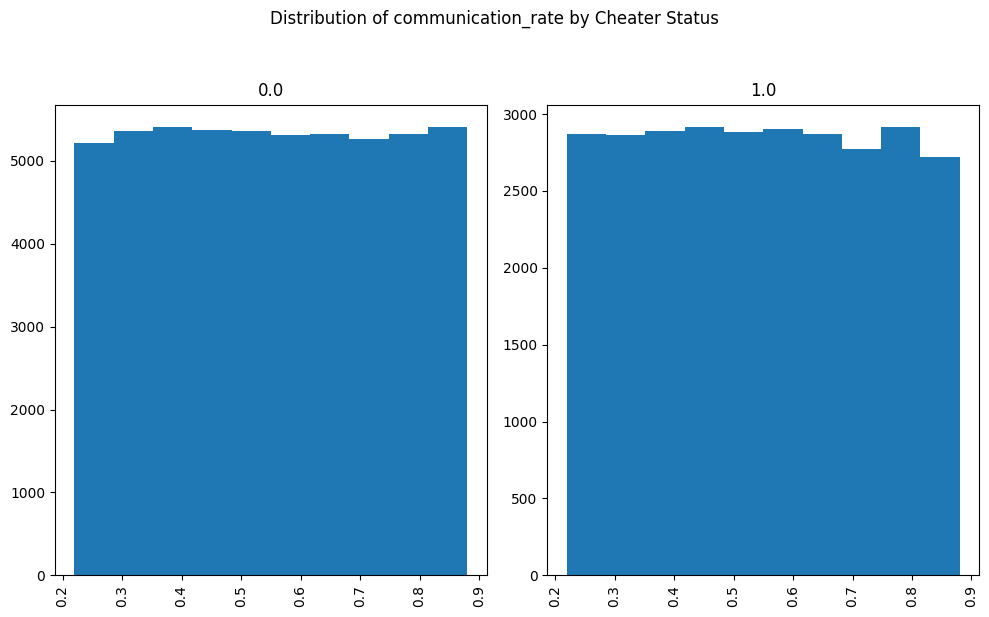

heww


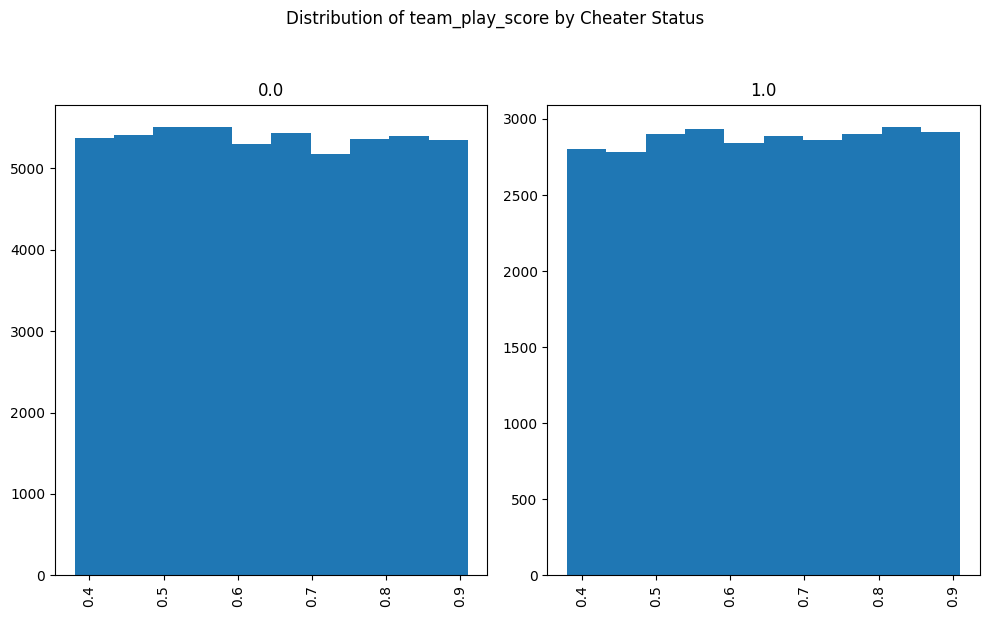

heww


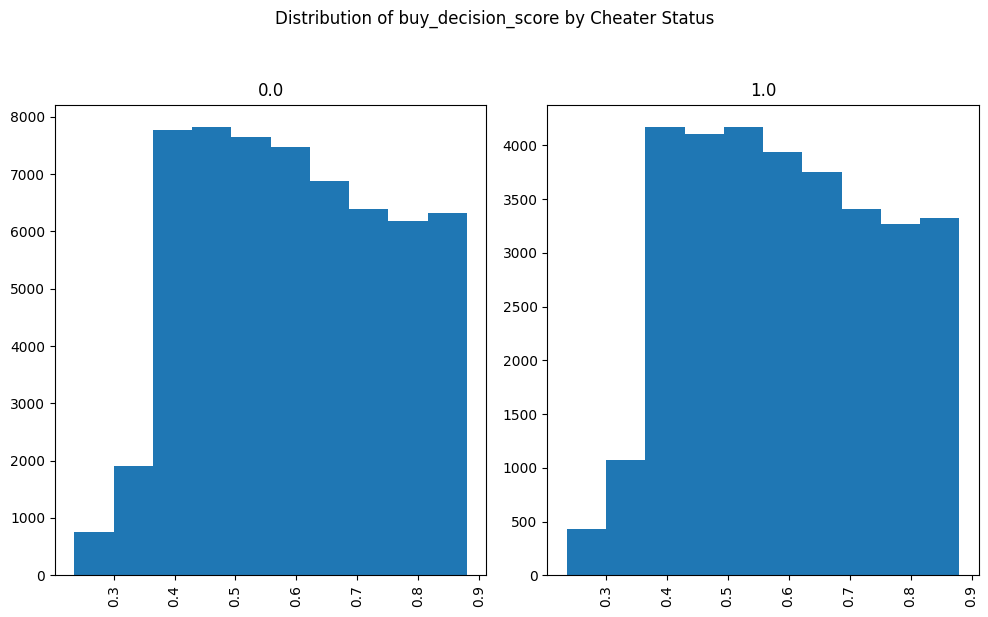

heww


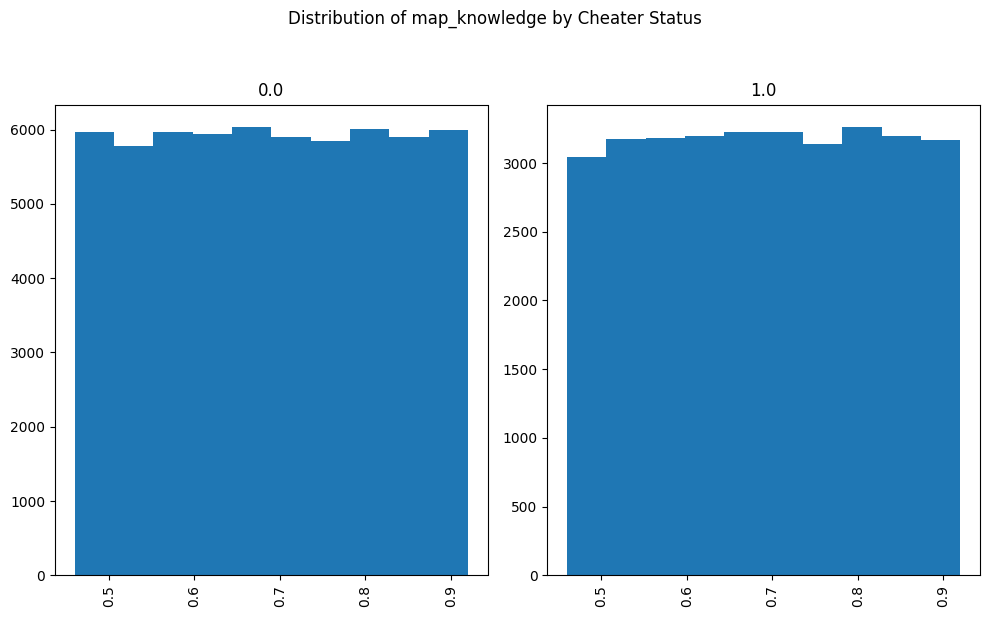

heww


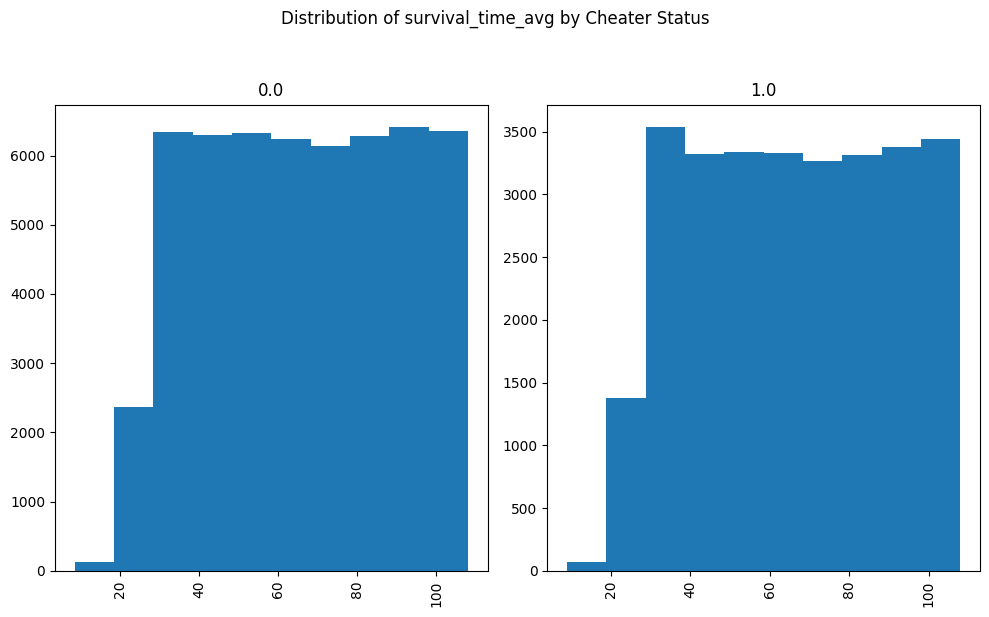

heww


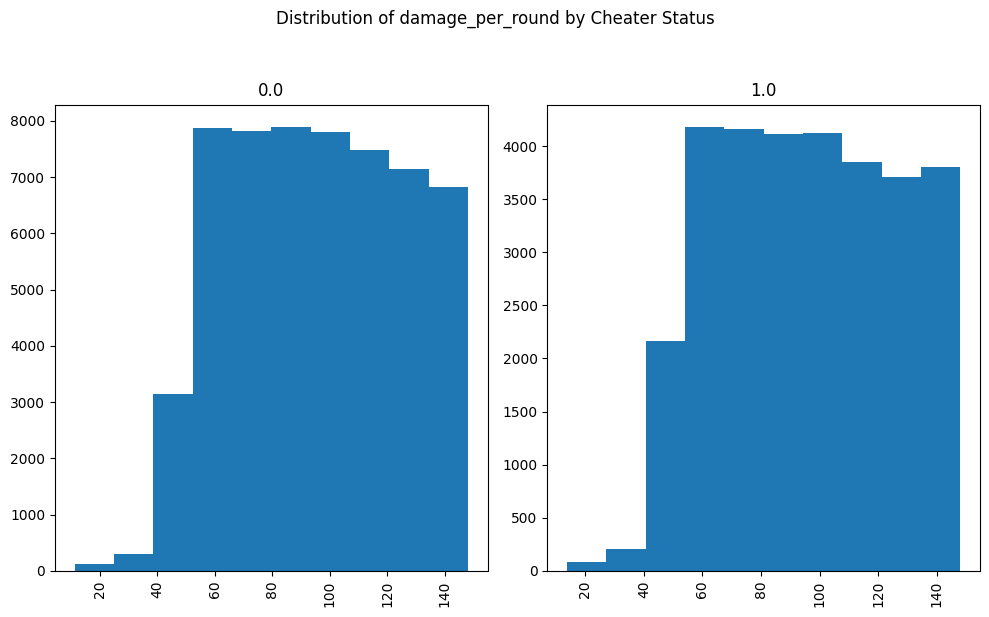

heww


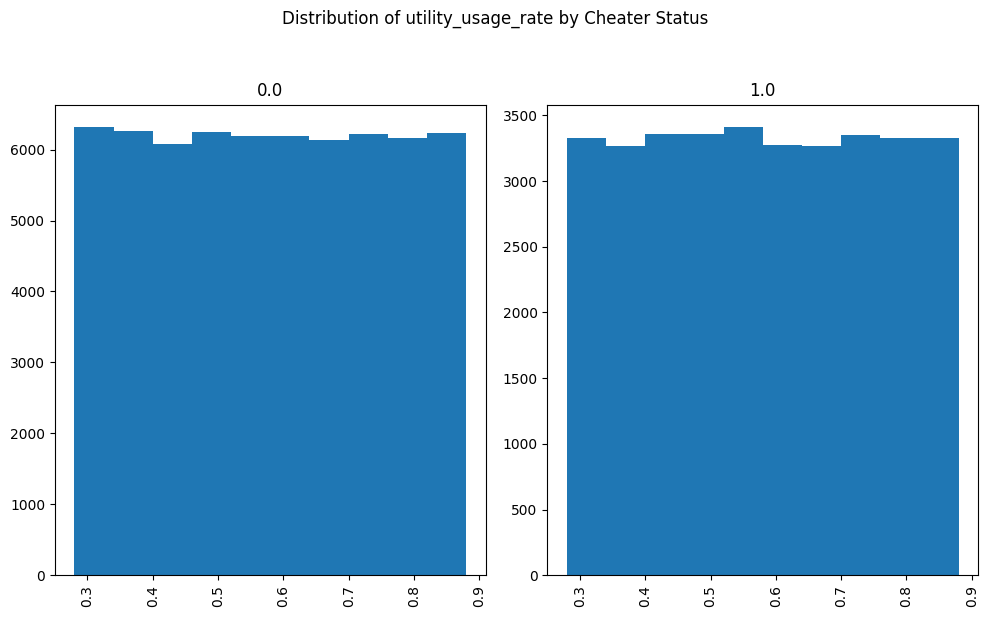

heww


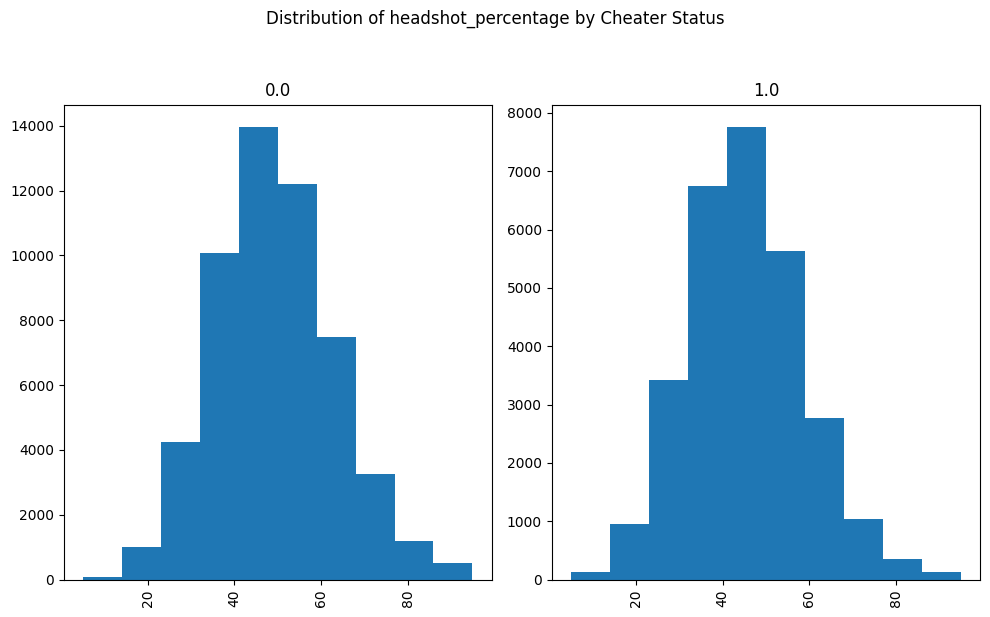

heww


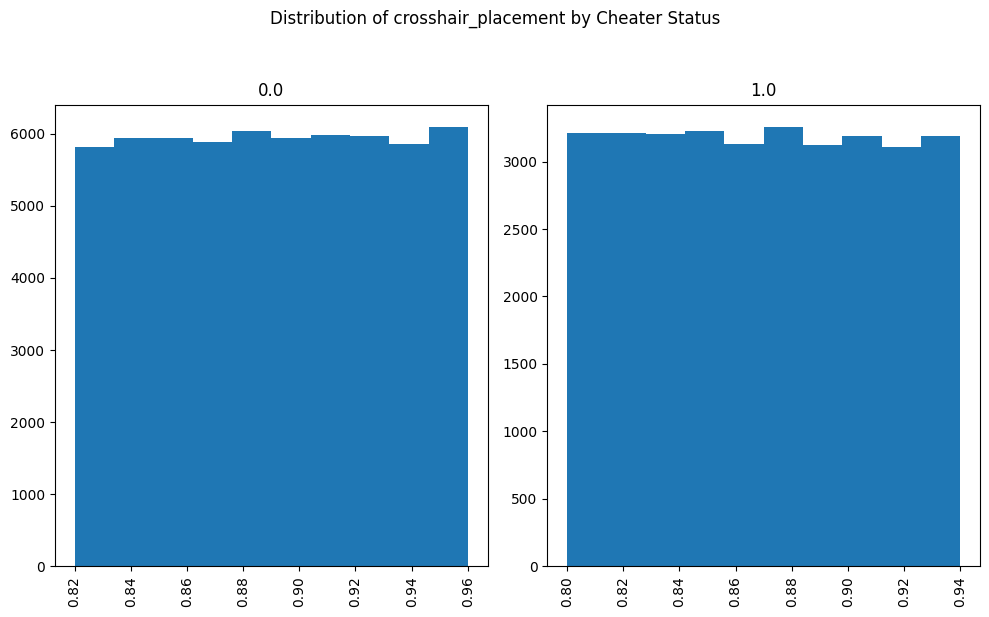

heww


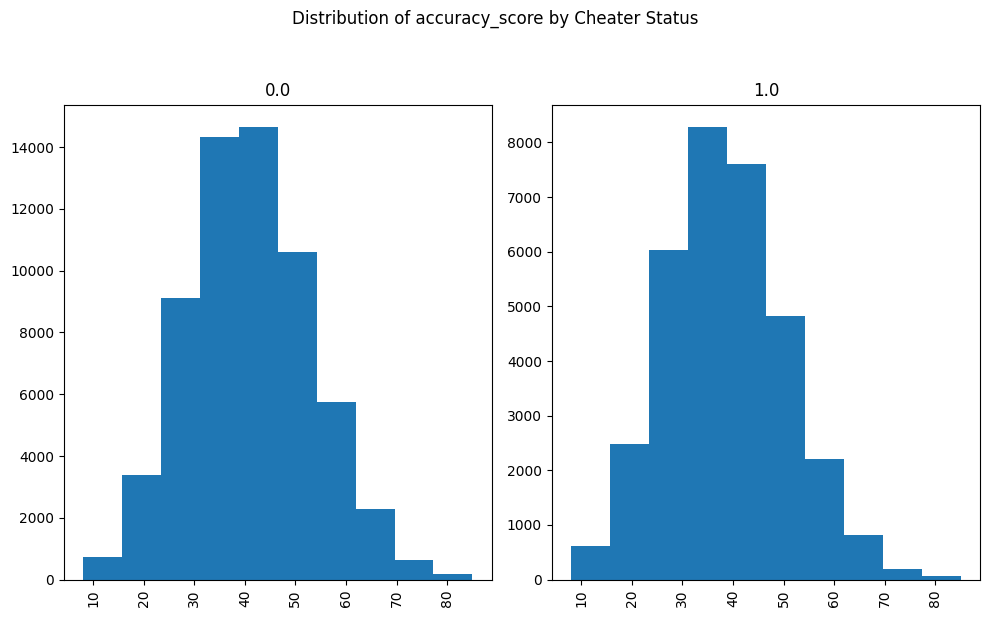

heww


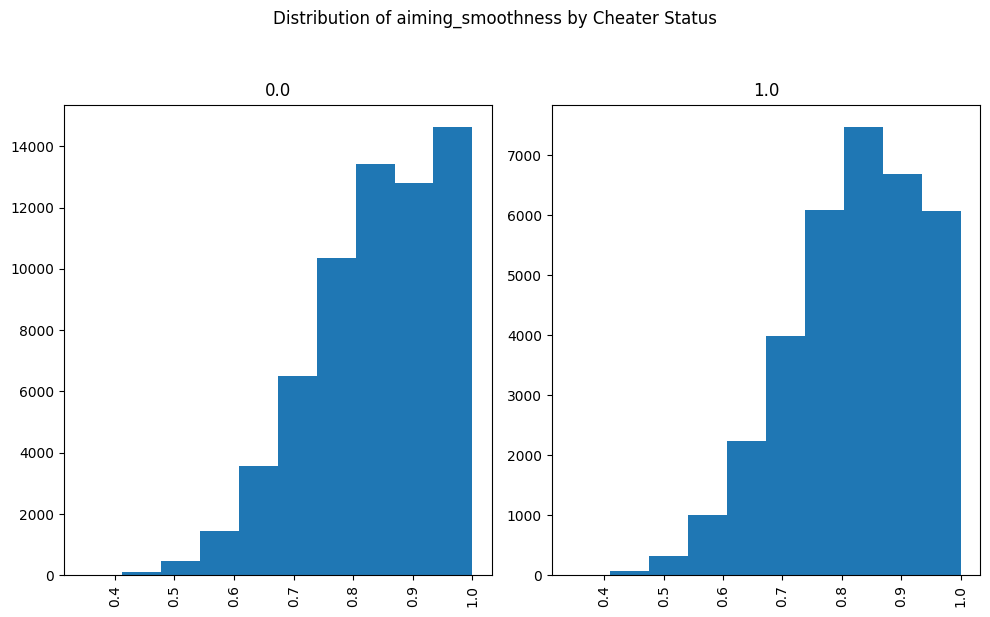

heww


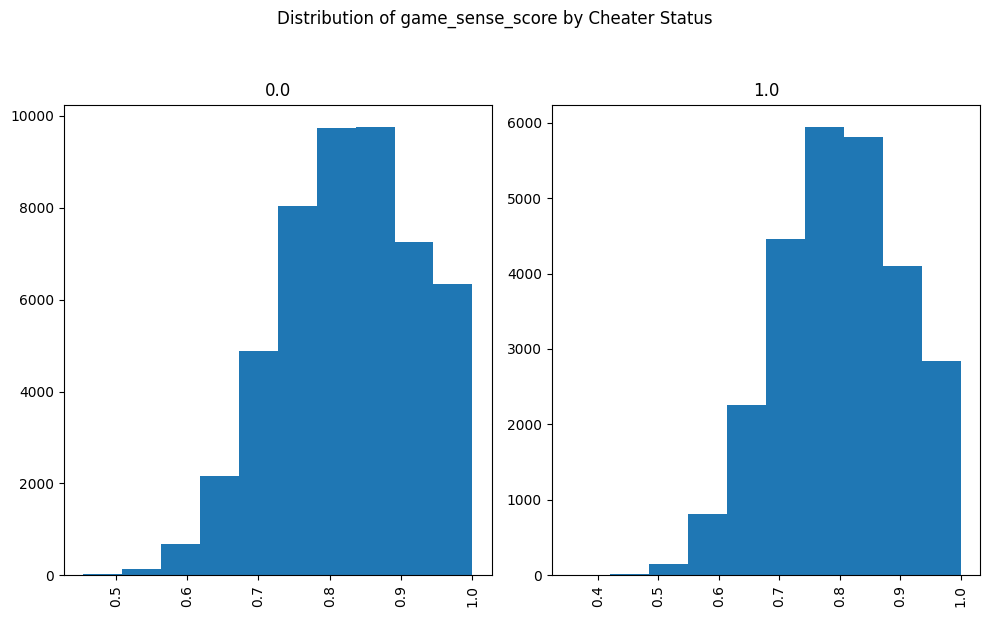

heww


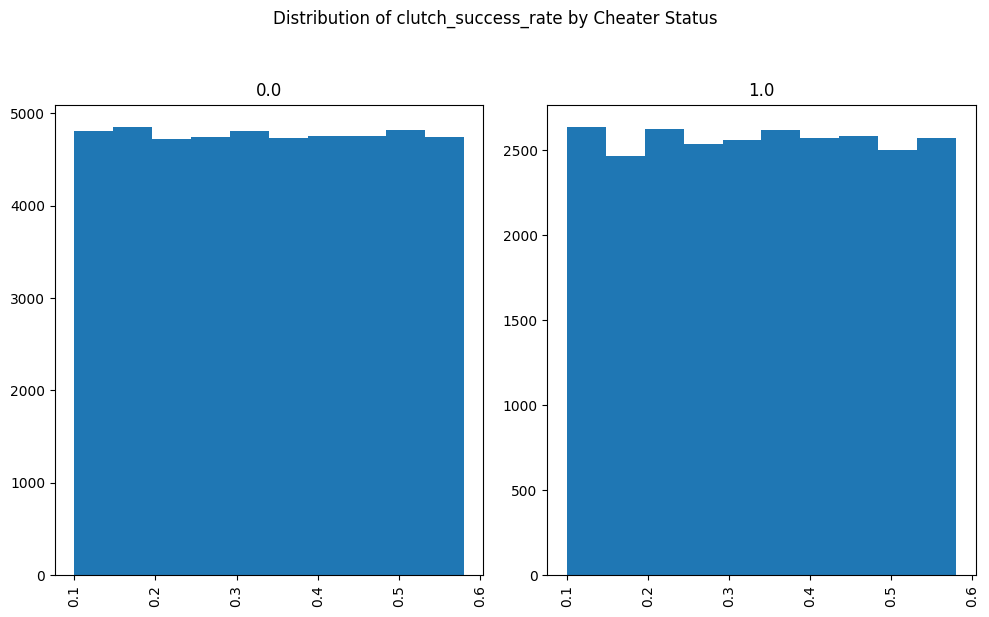

heww


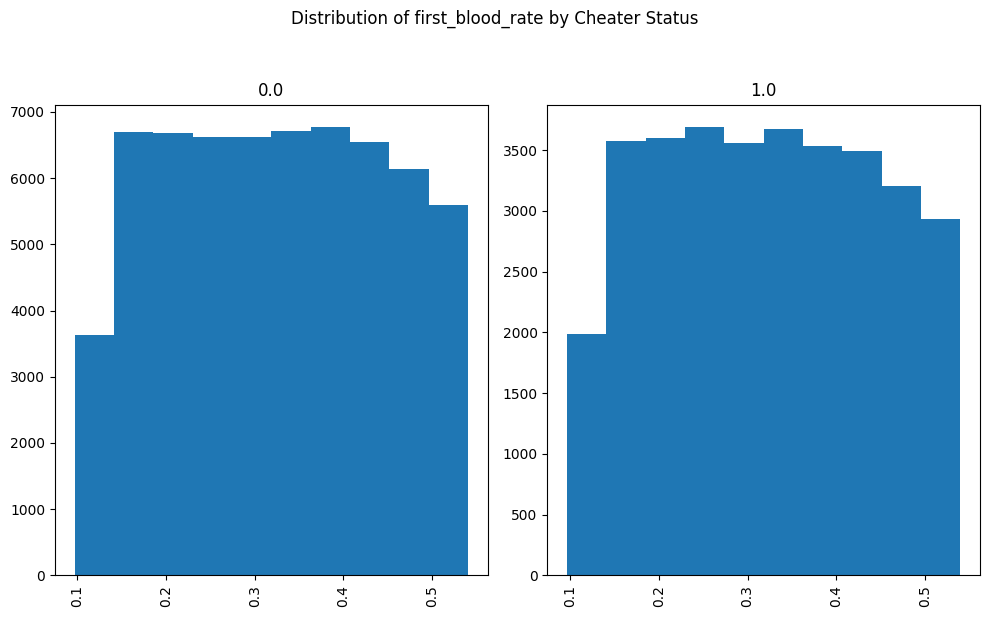

heww


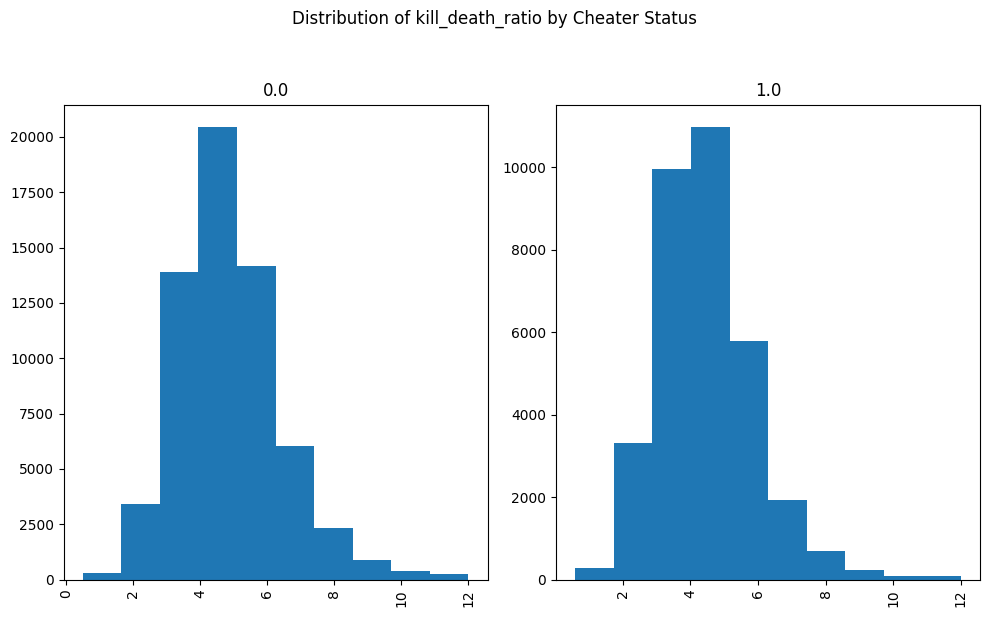

heww


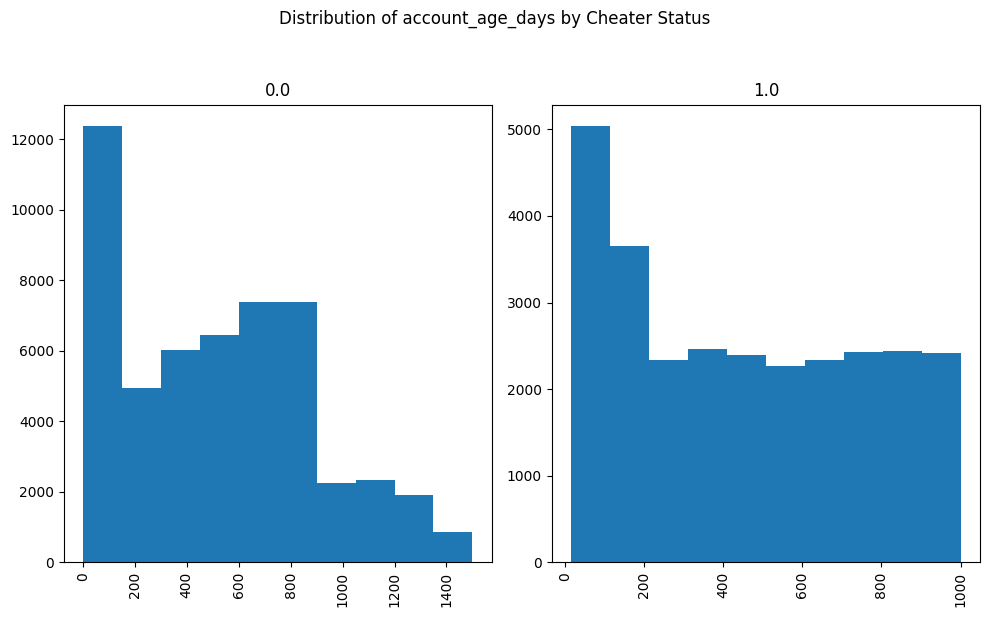

heww


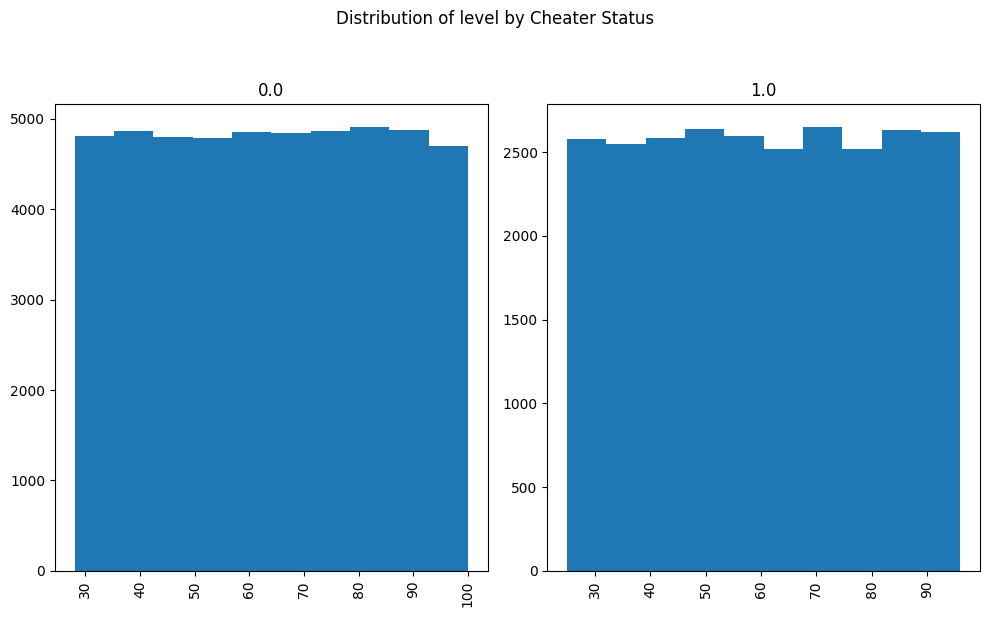

heww


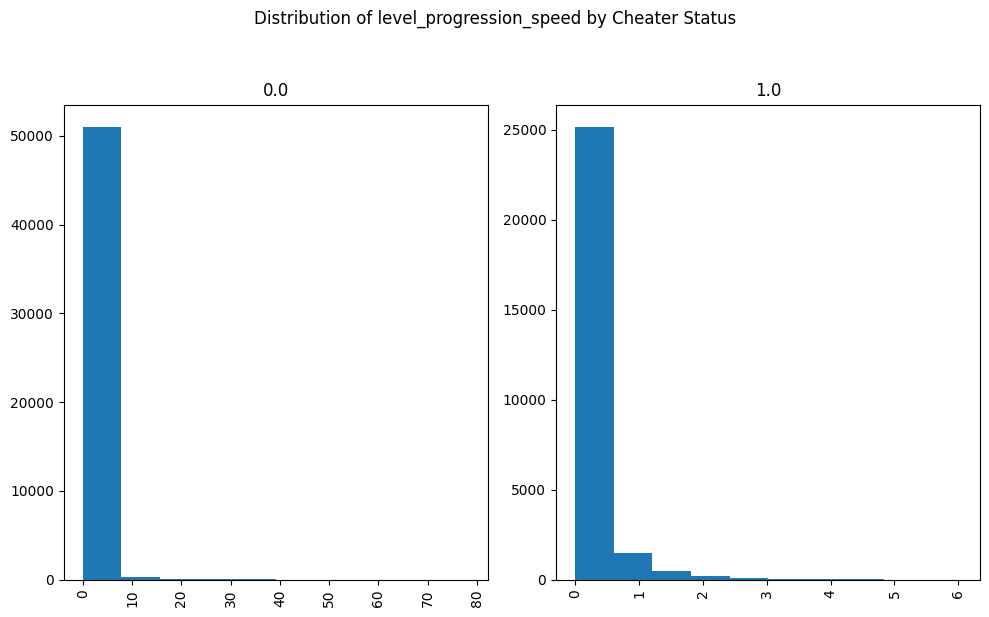

heww


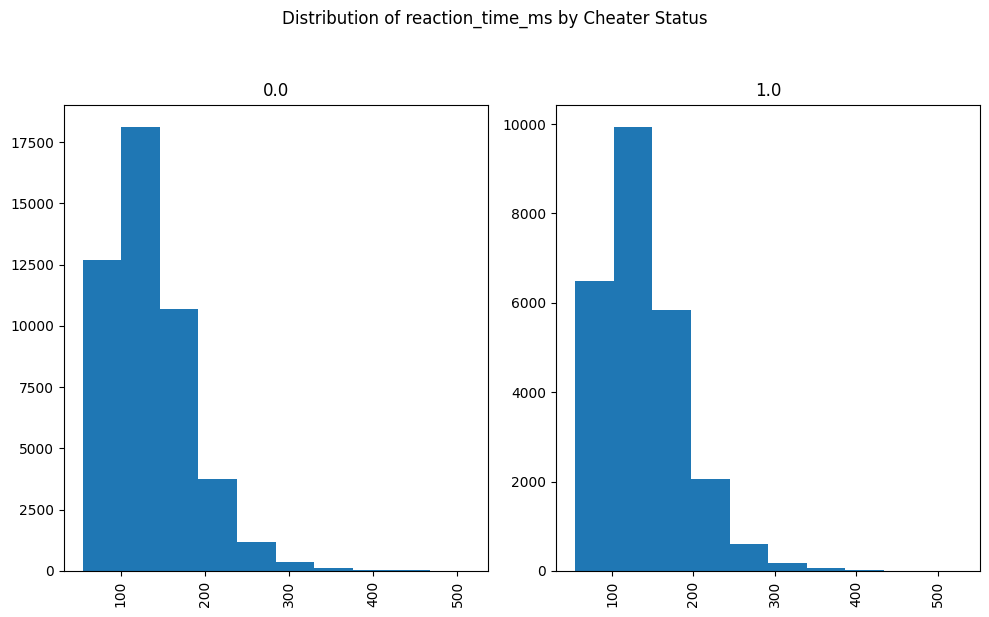

heww


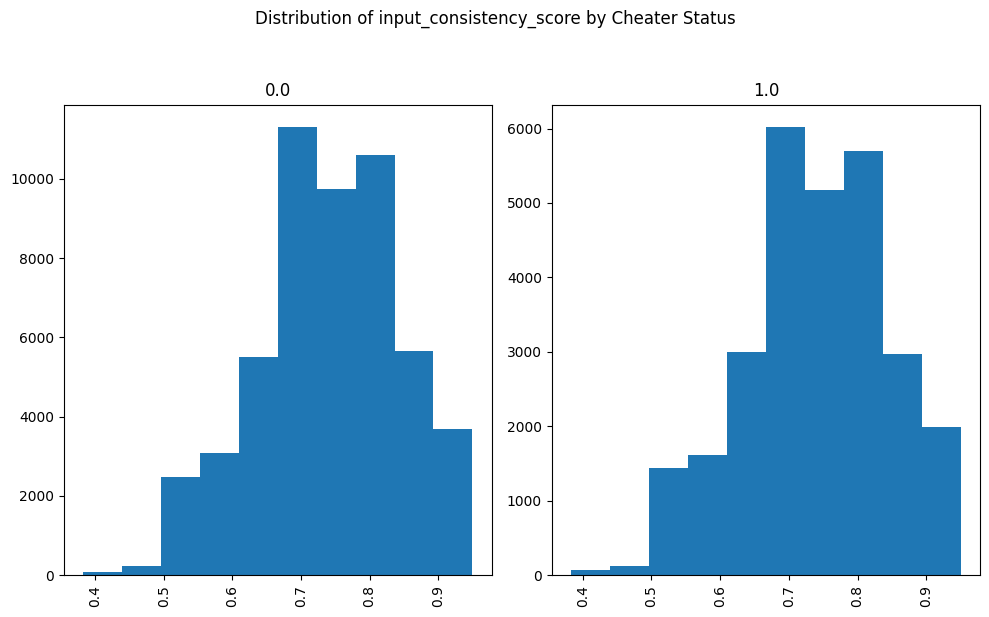

heww


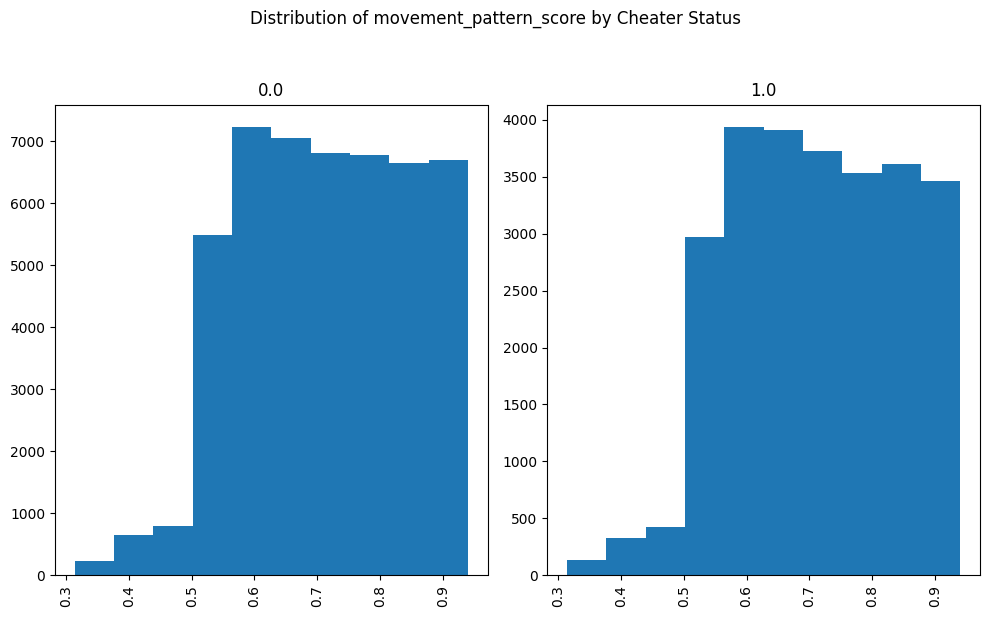

heww


KeyError: 'inhuman_aim_score'

In [ ]:
columns_to_plot = df.drop(columns=['id', 'player_id'], errors='ignore').columns

for col in columns_to_plot:
    if df[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(10, 6))
        df.hist(column=col, by='is_cheater', ax=plt.gca())
        plt.suptitle(f'Distribution of {col} by Cheater Status', y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        print("heww")

In [ ]:
# mask = (df["headshot_percentage"] < 20) & (df["win_rate"] < 30) & (df["is_cheater"].isnull())
# filled_count = mask.sum()
# df.loc[mask, "is_cheater"] = 1

# print(f"Filled {filled_count} rows.")
# print(df['is_cheater'].value_counts(dropna=False))


Filled 0 rows.
is_cheater
0.0    63619
1.0    34129
NaN     2124
Name: count, dtype: int64


In [ ]:
# mask = ((df["headshot_percentage"] <  20 ) & (df["win_rate"]< 30) & (df["is_cheater"].isnull()))
# filled_count = mask.sum()
# df.loc[mask, "is_cheater"] = 1

# print(f"Filled {filled_count} rows.")
# print(df['is_cheater'].value_counts(dropna=False))


# df.loc[(df["headshot_percentage"] <  20 ) & (df["win_rate"]< 30) & (df["is_cheater"].isnull()), "is_cheater"] = 1
# print(df['is_cheater'].value_counts(dropna=False))

Filled 0 rows.
is_cheater
0.0    63619
1.0    34129
NaN     2124
Name: count, dtype: int64


#fill missing values

In [ ]:
df = df.dropna(subset=["is_cheater"])

In [ ]:
# df = df.drop(columns=['avg_session_length_min', 'sessions_per_day', 'night_play_ratio'], errors='ignore')

In [ ]:
df.fillna({"reports_received":0}, inplace=True)

In [ ]:

# df = df.drop(columns=['avg_session_length_min', 'sessions_per_day', 'night_play_ratio'], errors='ignore')

# final code data prep


In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# --- 1. MICE ---
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# ---------------- Load Data ----------------
df = pd.read_csv("/content/public_dataset/task1/train.csv")
dftest = pd.read_csv("/content/public_dataset/task1/test.csv")


# ============================================================
# 2. Custom Feature Engineer
# ============================================================

class CheatFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = X.copy()
        epsilon = 1e-6

        X_new["inhuman_aim_score"] = (
            X_new["headshot_percentage"] / (X_new["crosshair_placement"] + epsilon)
        )

        X_new["aim_snap_score"] = (
            (X_new["headshot_percentage"] * X_new["accuracy_score"]) /
            (X_new["aiming_smoothness"] + epsilon)
        )

        X_new["info_score"] = (
            X_new["game_sense_score"] *
            X_new["clutch_success_rate"] *
            X_new["first_blood_rate"]
        )

        X_new["kill_rate_per_day"] = (
            X_new["kill_death_ratio"] / (X_new["account_age_days"] + epsilon)
        )

        X_new.replace([np.inf, -np.inf], 0, inplace=True)
        return X_new


# ============================================================
# 3. Feature Selector (now before scaling)
# ============================================================

class FeatureSelectorCumulative(BaseEstimator, TransformerMixin):
    def __init__(self, cumulative_threshold=0.80):
        self.cumulative_threshold = cumulative_threshold
        self.selected_features_ = []
        self.selected_idx_ = []

    def _ensure_dataframe(self, X):
        """Convert ndarray → DataFrame with safe column names"""
        if isinstance(X, pd.DataFrame):
            return X, list(X.columns)
        else:
            cols = [f"f{i}" for i in range(X.shape[1])]
            return pd.DataFrame(X, columns=cols), cols

    def fit(self, X, y):
        # Here X SHOULD be a DataFrame (because we moved this before StandardScaler)
        X_df, cols = self._ensure_dataframe(X)

        model = RandomForestClassifier(
            n_estimators=50, random_state=42, n_jobs=-1
        )
        model.fit(X_df, y)

        importances = pd.Series(model.feature_importances_, index=cols)
        importances = importances.sort_values(ascending=False)
        cumulative_sum = importances.cumsum()

        self.selected_features_ = cumulative_sum[cumulative_sum <= self.cumulative_threshold].index.tolist()

        if not self.selected_features_:
            self.selected_features_ = [importances.index[0]]

        self.selected_idx_ = [cols.index(c) for c in self.selected_features_]

        print(f"[FeatureSelector] Keeping {len(self.selected_features_)} / {len(cols)} features")
        print(f"[Top 3] {self.selected_features_[:3]}")
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.selected_features_]
        else:
            return X[:, self.selected_idx_]


# ============================================================
# 4. Column Groups
# ============================================================

zero_impute_cols = ["reports_received"]

mice_impute_cols = [
    "headshot_percentage", "crosshair_placement", "accuracy_score",
    "aiming_smoothness", "game_sense_score", "clutch_success_rate",
    "first_blood_rate", "kill_death_ratio", "account_age_days",
    "level", "level_progression_speed", "reaction_time_ms",
    "input_consistency_score", "movement_pattern_score",
]

median_impute_cols = [
    "win_rate", "kill_consistency", "friend_network_size", "device_changes_count",
    "avg_session_length_min", "sessions_per_day", "night_play_ratio",
    "weapon_switch_speed", "spray_control_score", "communication_rate",
    "team_play_score", "buy_decision_score", "map_knowledge",
    "survival_time_avg", "damage_per_round", "utility_usage_rate",
]

original_feature_order = zero_impute_cols + median_impute_cols + mice_impute_cols


# ============================================================
# 5. ColumnTransformer + Pipeline
# ============================================================

preprocessor = ColumnTransformer(
    transformers=[
        ("zero", SimpleImputer(strategy="constant", fill_value=0), zero_impute_cols),
        ("median", SimpleImputer(strategy="median"), median_impute_cols),
        ("mice", IterativeImputer(max_iter=10, random_state=42), mice_impute_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
).set_output(transform="pandas")

preprocessing_pipeline = Pipeline(steps=[
    ("1_preprocessing", preprocessor),
    ("2_feature_engineering", CheatFeatureEngineer()),
    # ⬇️ Feature selection while columns are still DataFrame with real names
    ("3_feature_selection", FeatureSelectorCumulative(cumulative_threshold=0.80)),
    # ⬇️ Scale AFTER we have selected features
    ("4_scaling", StandardScaler()),
])


# ============================================================
# 6. Execute Pipeline
# ============================================================

df_clean = df.dropna(subset=["is_cheater"]).copy()
y = df_clean["is_cheater"]
X_train_raw = df_clean[original_feature_order]
X_test_raw = dftest[original_feature_order]

print("Fitting pipeline on train...")
train_array = preprocessing_pipeline.fit_transform(X_train_raw, y)

print("Transforming test...")
test_array = preprocessing_pipeline.transform(X_test_raw)


# ============================================================
# 7. Convert back to DataFrame + keep target
# ============================================================

selected_cols = preprocessing_pipeline.named_steps["3_feature_selection"].selected_features_

train_df = pd.DataFrame(train_array, columns=selected_cols, index=X_train_raw.index)
test_df = pd.DataFrame(test_array, columns=selected_cols, index=X_test_raw.index)

# 🔹 Add target back into train_df
train_df["is_cheater"] = y.values

print("\nFinal train_df shape:", train_df.shape)
print("Final test_df shape:", test_df.shape)
print("Feature Columns:", selected_cols)
print("train_df columns (with target):", train_df.columns.tolist())


Fitting pipeline on train...
[FeatureSelector] Keeping 23 / 35 features
[Top 3] ['crosshair_placement', 'reports_received', 'friend_network_size']
Transforming test...

Final train_df shape: (97748, 24)
Final test_df shape: (25889, 23)
Feature Columns: ['crosshair_placement', 'reports_received', 'friend_network_size', 'account_age_days', 'level', 'kill_rate_per_day', 'game_sense_score', 'kill_death_ratio', 'headshot_percentage', 'aim_snap_score', 'level_progression_speed', 'spray_control_score', 'inhuman_aim_score', 'aiming_smoothness', 'accuracy_score', 'win_rate', 'kill_consistency', 'avg_session_length_min', 'utility_usage_rate', 'input_consistency_score', 'movement_pattern_score', 'reaction_time_ms', 'night_play_ratio']
train_df columns (with target): ['crosshair_placement', 'reports_received', 'friend_network_size', 'account_age_days', 'level', 'kill_rate_per_day', 'game_sense_score', 'kill_death_ratio', 'headshot_percentage', 'aim_snap_score', 'level_progression_speed', 'spray_co

#impute with mice all column (score not good )

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer

# # --- 1. MICE ---
# from sklearn.experimental import enable_iterative_imputer  # ต้อง import ก่อน IterativeImputer
# from sklearn.impute import IterativeImputer


# # ---------------- Load Data ----------------
# df = pd.read_csv("/content/public_dataset/task1/train.csv")
# dftest = pd.read_csv("/content/public_dataset/task1/test.csv")


# # ============================================================
# # 2. Custom Feature Engineer
# # ============================================================

# class CheatFeatureEngineer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         X_new = X.copy()
#         epsilon = 1e-6

#         X_new["inhuman_aim_score"] = (
#             X_new["headshot_percentage"] / (X_new["crosshair_placement"] + epsilon)
#         )

#         X_new["aim_snap_score"] = (
#             (X_new["headshot_percentage"] * X_new["accuracy_score"]) /
#             (X_new["aiming_smoothness"] + epsilon)
#         )

#         X_new["info_score"] = (
#             X_new["game_sense_score"] *
#             X_new["clutch_success_rate"] *
#             X_new["first_blood_rate"]
#         )

#         X_new["kill_rate_per_day"] = (
#             X_new["kill_death_ratio"] / (X_new["account_age_days"] + epsilon)
#         )

#         X_new.replace([np.inf, -np.inf], 0, inplace=True)
#         return X_new


# # ============================================================
# # 3. Define columns (drop nonsense by logic)
# # ============================================================

# target_col = "is_cheater"
# id_col = "id"

# # 👇 ฟีเจอร์ที่ “ไม่ควรใช้เป็น feature”
# # - id, player_id = ตัวระบุ, ไม่มีความหมายเชิงพฤติกรรม
# logic_drop_cols = [id_col, "player_id", target_col]

# # ใช้ทุกคอลัมน์ที่เหลือเป็น feature
# feature_cols = [c for c in df.columns if c not in logic_drop_cols]

# print("Feature columns used (after logic drop):")
# print(feature_cols)
# print("Total features:", len(feature_cols))


# # ============================================================
# # 4. ColumnTransformer + Pipeline (ALL MICE)
# # ============================================================

# # ใช้ MICE กับทุก feature column ที่เหลือ
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("mice_all", IterativeImputer(max_iter=10, random_state=42), feature_cols),
#     ],
#     remainder="drop",
#     verbose_feature_names_out=False,
# ).set_output(transform="pandas")

# # Pipeline:
# #  1) Impute ด้วย MICE (ทุกฟีเจอร์)
# #  2) Feature engineering เพิ่ม 4 ฟีเจอร์
# #  3) Scaling ด้วย StandardScaler
# preprocessing_pipeline = Pipeline(steps=[
#     ("1_preprocessing_mice", preprocessor),
#     ("2_feature_engineering", CheatFeatureEngineer()),
#     ("3_scaling", StandardScaler()),
# ])


# # ============================================================
# # 5. Execute Pipeline
# # ============================================================

# # ใช้เฉพาะแถวที่มี target
# df_clean = df.dropna(subset=[target_col]).copy()
# y = df_clean[target_col]

# # X ดิบสำหรับ train/test (หลังตัดฟีเจอร์ไร้สาระ)
# X_train_raw = df_clean[feature_cols]
# X_test_raw = dftest[feature_cols]

# print("\nFitting pipeline on train...")
# train_array = preprocessing_pipeline.fit_transform(X_train_raw, y)

# print("Transforming test...")
# test_array = preprocessing_pipeline.transform(X_test_raw)


# # ============================================================
# # 6. Rebuild DataFrames (no feature selection)
# # ============================================================

# # ชื่อคอลัมน์หลัง feature engineering:
# # = original feature_cols + 4 ฟีเจอร์ใหม่
# engineered_feature_names = feature_cols + [
#     "inhuman_aim_score",
#     "aim_snap_score",
#     "info_score",
#     "kill_rate_per_day",
# ]

# train_df = pd.DataFrame(train_array, columns=engineered_feature_names, index=df_clean.index)
# test_df = pd.DataFrame(test_array, columns=engineered_feature_names, index=X_test_raw.index)

# # 🔹 Add target back into train_df (ตามที่คุณอยากให้มี target อยู่ด้วย)
# train_df[target_col] = y.values

# print("\nFinal train_df shape:", train_df.shape)
# print("Final test_df shape:", test_df.shape)
# print("train_df columns (with target at the end):")
# print(train_df.columns.tolist())


Feature columns used (after logic drop):
['kill_death_ratio', 'headshot_percentage', 'win_rate', 'accuracy_score', 'kill_consistency', 'reaction_time_ms', 'account_age_days', 'level', 'level_progression_speed', 'friend_network_size', 'reports_received', 'device_changes_count', 'input_consistency_score', 'avg_session_length_min', 'sessions_per_day', 'night_play_ratio', 'weapon_switch_speed', 'movement_pattern_score', 'aiming_smoothness', 'spray_control_score', 'game_sense_score', 'communication_rate', 'team_play_score', 'buy_decision_score', 'map_knowledge', 'clutch_success_rate', 'first_blood_rate', 'survival_time_avg', 'damage_per_round', 'utility_usage_rate', 'crosshair_placement']
Total features: 31

Fitting pipeline on train...
Transforming test...

Final train_df shape: (97748, 36)
Final test_df shape: (25889, 35)
train_df columns (with target at the end):
['kill_death_ratio', 'headshot_percentage', 'win_rate', 'accuracy_score', 'kill_consistency', 'reaction_time_ms', 'account_age

#model


In [ ]:
test_df


,crosshair_placement,reports_received,friend_network_size,account_age_days,level,kill_rate_per_day,game_sense_score,kill_death_ratio,headshot_percentage,aim_snap_score,...,aiming_smoothness,accuracy_score,win_rate,kill_consistency,avg_session_length_min,utility_usage_rate,input_consistency_score,movement_pattern_score,reaction_time_ms,night_play_ratio
0,-1.816708,0.573408,1.266725,0.179123,-2.009397,-0.171032,-1.001568,0.050973,-0.025251,-0.154414,...,0.442557,0.062286,1.064127,-0.721433,1.522990,1.605018,0.407960,-0.921960,1.558324,0.526824
1,0.032138,1.257462,-0.330115,0.690334,-1.793808,-0.183785,0.450652,-0.167820,0.521811,-0.082670,...,1.469033,0.133003,-0.331111,1.463623,0.429888,-1.001147,0.098752,-0.027143,-1.200258,-0.512825
2,-1.505567,0.162975,-0.563500,0.090161,0.372310,-0.146918,0.019715,1.499696,-0.792075,-0.439918,...,0.796751,0.523348,0.384091,0.022129,0.952248,-1.715026,-0.251003,-0.701382,0.140021,-1.580542
3,1.903771,0.983841,1.168458,1.848432,-1.162171,-0.192389,2.048761,0.181328,-0.284721,-0.577660,...,0.140993,-0.548311,-0.114169,2.086395,-0.895451,0.270865,2.071168,-1.486224,-0.530408,-0.001016
4,-0.272886,1.257462,-1.189953,-1.208695,1.124627,-0.070852,-0.336617,-1.127249,-0.202971,-0.811754,...,0.499027,-0.892733,-0.005604,-0.544309,1.598254,1.138810,-0.228689,-0.385572,-1.104086,0.616569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25884,0.432297,0.710219,-1.288220,-1.351193,-0.034911,0.147383,-0.186529,-0.209828,-1.114712,-0.914071,...,0.892053,-0.125242,-1.697451,1.453629,-1.436422,-1.392138,0.725606,-0.612400,-1.656588,1.387556
25885,-1.291805,0.299786,0.738539,1.322326,-2.060484,-0.203736,-2.023086,-1.664368,0.894463,0.481796,...,1.013770,0.492026,0.860123,-0.262152,1.154114,1.090094,0.615266,-0.007727,-1.612888,-0.690311
25886,-0.055131,0.026165,-0.023031,-0.217721,1.519068,-0.132968,-1.424909,1.384529,2.799832,1.474327,...,0.888220,0.318220,0.890293,0.022129,1.528452,0.001061,-0.696225,-1.084606,0.450912,0.128366
25887,-0.013395,1.667895,-1.472471,-1.516651,0.018523,5.000196,-0.087679,3.787774,-0.211596,-1.166814,...,0.231838,-1.573649,0.338203,-0.017532,1.641607,-0.003473,0.306611,-0.299043,-0.692084,-0.913758


In [ ]:
train_df.to_csv('train_processed_mice.csv', index=False)
test_df.to_csv('test_processed_mice.csv', index=False)
print("done")

done


In [ ]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.6


Found existing installation: xgboost 3.1.1
Uninstalling xgboost-3.1.1:
  Successfully uninstalled xgboost-3.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.7 MB/s eta 0:00:00


In [ ]:
df = df.drop(columns=["player_id"], errors="ignore")
dftest = dftest.drop(columns=["player_id"], errors="ignore")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data
train_df = pd.read_csv("/content/train_processed_mice.csv")
test_df = pd.read_csv("/content/test_processed_mice.csv")
# train_df = df
# test_df = dftest


# train_df = train_df.dropna(subset=["is_cheater"])

target_col = "is_cheater"
id_col = "id"

# Prepare features and target
X = train_df.drop(columns=[target_col, id_col], errors="ignore")
y = train_df[target_col]
X_test = test_df.drop(columns=[id_col], errors="ignore")

# ============================================================================
# 1. ADVANCED FEATURE SELECTION WITH IMPORTANCE ANALYSIS
# ============================================================================
def feature_selection_with_cv(X, y, n_folds=5):
    """Select best features using cross-validation importance"""
    print("🔍 Performing feature selection...")

    # Quick model for feature importance
    temp_model = lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        verbose=-1
    )

    # Get importance across CV folds
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    importance_list = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        temp_model.fit(X_tr, y_tr)
        importance_list.append(temp_model.feature_importances_)

    # Average importance
    avg_importance = np.mean(importance_list, axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importance
    }).sort_values('importance', ascending=False)

    # Select top features (keep 80% of total importance)
    cumsum = feature_importance_df['importance'].cumsum()
    threshold = cumsum.max() * 0.95
    selected_features = feature_importance_df[cumsum <= threshold]['feature'].tolist()

    print(f"✅ Selected {len(selected_features)}/{len(X.columns)} features")
    return selected_features

selected_features = feature_selection_with_cv(X, y)
X_selected = X[selected_features]
X_test_selected = X_test[selected_features]

# ============================================================================
# 2. HYPERPARAMETER OPTIMIZATION FOR MULTIPLE MODELS
# ============================================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM Optimization
def objective_lgb(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              callbacks=[lgb.early_stopping(50, verbose=False)])

    preds = model.predict(X_valid)
    return f1_score(y_valid, preds)

# XGBoost Optimization
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'gpu_hist',
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'random_state': 42,
        'verbosity': 0
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              verbose=False)

    preds = model.predict(X_valid)
    return f1_score(y_valid, preds)

# CatBoost Optimization
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'eval_metric': 'F1',
        'verbose': 0,
        'random_seed': 42,
        'task_type': 'GPU'
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)

    preds = model.predict(X_valid)
    return f1_score(y_valid, preds)

# Optimize each model
print("\n🚀 Optimizing LightGBM...")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)
print(f"✅ Best LightGBM F1: {study_lgb.best_value:.4f}")

print("\n🚀 Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
print(f"✅ Best XGBoost F1: {study_xgb.best_value:.4f}")

print("\n🚀 Optimizing CatBoost...")
study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)
print(f"✅ Best CatBoost F1: {study_cat.best_value:.4f}")

# ============================================================================
# 3. ENSEMBLE WITH CROSS-VALIDATION
# ============================================================================
print("\n🎯 Training ensemble with cross-validation...")

def train_with_cv(X, y, X_test, n_folds=5):
    """Train ensemble with stratified k-fold CV"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    oof_preds = np.zeros(len(X))
    test_preds = np.zeros((len(X_test), n_folds, 3))  # 3 models

    metrics = {
        'f1': [], 'precision': [], 'recall': [], 'auc': []
    }

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n📊 Fold {fold}/{n_folds}")

        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # LightGBM
        lgb_params = study_lgb.best_params.copy()
        lgb_params.update({'objective': 'binary', 'metric': 'binary_logloss',
                          'verbose': -1, 'device': 'gpu', 'random_state': 42})
        lgb_model = lgb.LGBMClassifier(**lgb_params)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                     callbacks=[lgb.early_stopping(50, verbose=False)])

        # XGBoost
        xgb_params = study_xgb.best_params.copy()
        xgb_params.update({'objective': 'binary:logistic', 'eval_metric': 'logloss',
                          'tree_method': 'gpu_hist', 'verbosity': 0, 'random_state': 42})
        xgb_model = xgb.XGBClassifier(**xgb_params)
        xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        # CatBoost
        cat_params = study_cat.best_params.copy()
        cat_params.update({'eval_metric': 'F1', 'verbose': 0,
                          'task_type': 'GPU', 'random_seed': 42})
        cat_model = CatBoostClassifier(**cat_params)
        cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=0)

        # Predictions
        lgb_pred_val = lgb_model.predict_proba(X_val)[:, 1]
        xgb_pred_val = xgb_model.predict_proba(X_val)[:, 1]
        cat_pred_val = cat_model.predict_proba(X_val)[:, 1]

        # Weighted ensemble (weights based on validation performance)
        ensemble_pred_val = (lgb_pred_val * 0.33 +
                            xgb_pred_val * 0.33 +
                            cat_pred_val * 0.34)

        oof_preds[val_idx] = ensemble_pred_val

        # Test predictions
        test_preds[:, fold-1, 0] = lgb_model.predict_proba(X_test)[:, 1]
        test_preds[:, fold-1, 1] = xgb_model.predict_proba(X_test)[:, 1]
        test_preds[:, fold-1, 2] = cat_model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        y_pred_binary = (ensemble_pred_val > 0.5).astype(int)
        metrics['f1'].append(f1_score(y_val, y_pred_binary))
        metrics['precision'].append(precision_score(y_val, y_pred_binary))
        metrics['recall'].append(recall_score(y_val, y_pred_binary))
        metrics['auc'].append(roc_auc_score(y_val, ensemble_pred_val))

        print(f"   F1: {metrics['f1'][-1]:.4f} | "
              f"Precision: {metrics['precision'][-1]:.4f} | "
              f"Recall: {metrics['recall'][-1]:.4f} | "
              f"AUC: {metrics['auc'][-1]:.4f}")

    # Print overall metrics
    print("\n" + "="*60)
    print("📈 CROSS-VALIDATION RESULTS:")
    print("="*60)
    for metric_name, values in metrics.items():
        print(f"{metric_name.upper():>10}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("="*60)

    # Average test predictions across folds
    test_preds_avg = test_preds.mean(axis=1)  # Average across folds
    final_test_preds = test_preds_avg.mean(axis=1)  # Average across models

    return oof_preds, final_test_preds, metrics

# Train ensemble
oof_predictions, test_predictions, cv_metrics = train_with_cv(
    X_selected, y, X_test_selected, n_folds=5
)

# ============================================================================
# 4. OPTIMAL THRESHOLD TUNING
# ============================================================================
print("\n🎯 Finding optimal threshold...")

thresholds = np.arange(0.3, 0.7, 0.01)
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred = (oof_predictions > threshold).astype(int)
    f1 = f1_score(y, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"✅ Optimal threshold: {best_threshold:.3f} (F1: {best_f1:.4f})")

# Final predictions
final_predictions = (test_predictions > best_threshold).astype(int)

# ============================================================================
# 5. SAVE RESULTS
# ============================================================================
id_col = "id"

# ใช้ id จาก dftest ดิบ
id_test = dftest[id_col].reset_index(drop=True)

# final_predictions ต้องมีความยาวเท่ากันกับ dftest
pred_series = pd.Series(final_predictions, name="is_cheater")

output = pd.DataFrame({
    id_col: id_test,
    "is_cheater": pred_series
})

print(f"\n📊 Prediction distribution:")
print(output['is_cheater'].value_counts())
print(f"\n💾 Saving predictions...")

output.to_csv("task1_ultimate_ensemble.csv", index=False)
print("✅ Saved: task1_ultimate_ensemble.csv")

# # Save OOF predictions for stacking
# oof_df = train_df[[id_col, target_col]].copy()
# oof_df['oof_prediction'] = oof_predictions
# oof_df.to_csv("oof_predictions.csv", index=False)
# print("✅ Saved: oof_predictions.csv")

# print("\n" + "="*60)
# print("🎉 TRAINING COMPLETE!")
# print("="*60)

🔍 Performing feature selection...


[I 2025-11-22 20:30:06,684] A new study created in memory with name: no-name-e784da47-2135-45c6-87e4-a723381cc03f


✅ Selected 20/23 features

🚀 Optimizing LightGBM...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-22 20:30:08,347] Trial 0 finished with value: 0.6876127973748974 and parameters: {'n_estimators': 749, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 2.9154431891537547, 'reg_lambda': 0.2537815508265665, 'min_gain_to_split': 0.7080725777960455}. Best is trial 0 with value: 0.6876127973748974.
[I 2025-11-22 20:30:10,286] Trial 1 finished with value: 0.6883674818241904 and parameters: {'n_estimators': 324, 'learning_rate': 0.2708160864249968, 'num_leaves': 129, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'reg_alpha': 0.12561043700013558, 'reg_lambda': 0.05342937261279776, 'min_gain_to_split': 0.2912291401980419}. Best is trial 1 with value: 0.6883674818241904.
[I 2025-11-22 20:30:21,219] Trial 2 finished with value: 0.6825731388584436 and parameters: {'n_estimators': 1034, 'l

[I 2025-11-22 20:34:36,504] A new study created in memory with name: no-name-a2b6563a-6685-4f0b-ae4e-6fefb2aebe44


[I 2025-11-22 20:34:36,496] Trial 49 finished with value: 0.6887098114148044 and parameters: {'n_estimators': 1418, 'learning_rate': 0.02647029309174634, 'num_leaves': 83, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.8744868904853941, 'colsample_bytree': 0.6883031759832292, 'reg_alpha': 0.014119447438690353, 'reg_lambda': 0.008734478005816561, 'min_gain_to_split': 0.530444570886904}. Best is trial 17 with value: 0.6917293233082706.
✅ Best LightGBM F1: 0.6917

🚀 Optimizing XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-22 20:34:43,330] Trial 0 finished with value: 0.6760146451663162 and parameters: {'n_estimators': 749, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.05808361216819946, 'reg_alpha': 2.9154431891537547, 'reg_lambda': 0.2537815508265665}. Best is trial 0 with value: 0.6760146451663162.
[I 2025-11-22 20:34:52,939] Trial 1 finished with value: 0.6890617243091179 and parameters: {'n_estimators': 1150, 'learning_rate': 0.010725209743171997, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.18340450985343382, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558}. Best is trial 1 with value: 0.6890617243091179.
[I 2025-11-22 20:34:58,568] Trial 2 finished with value: 0.6909688013136289 and parameters: {'n_estimators': 818, 'learning_rate': 0.02692655251486473, 'max_depth': 9, 'min_ch

[I 2025-11-22 20:39:02,829] A new study created in memory with name: no-name-11e56709-47e0-4ccf-80d5-99221a99cc65


[I 2025-11-22 20:39:02,822] Trial 49 finished with value: 0.6876199616122841 and parameters: {'n_estimators': 1424, 'learning_rate': 0.035224942342752405, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.6077737086333508, 'colsample_bytree': 0.7481334849672606, 'gamma': 0.6093724362448748, 'reg_alpha': 4.2145945698897815, 'reg_lambda': 2.6838585603250213}. Best is trial 48 with value: 0.6930900871811431.
✅ Best XGBoost F1: 0.6931

🚀 Optimizing CatBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-22 20:39:20,723] Trial 0 finished with value: 0.6830991569650743 and parameters: {'iterations': 749, 'depth': 10, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'border_count': 66, 'bagging_temperature': 0.15599452033620265, 'random_strength': 0.05808361216819946, 'min_data_in_leaf': 44}. Best is trial 0 with value: 0.6830991569650743.
[I 2025-11-22 20:39:32,649] Trial 1 finished with value: 0.6803843210611342 and parameters: {'iterations': 1021, 'depth': 8, 'learning_rate': 0.010725209743171997, 'l2_leaf_reg': 9.72918866945795, 'border_count': 218, 'bagging_temperature': 0.21233911067827616, 'random_strength': 0.18182496720710062, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.6830991569650743.
[I 2025-11-22 20:39:37,889] Trial 2 finished with value: 0.6880349051854338 and parameters: {'iterations': 665, 'depth': 7, 'learning_rate': 0.04345454109729477, 'l2_leaf_reg': 3.6210622617823773, 'border_count': 169, 'bagging_temperature': 0.139493860

KeyError: "['id'] not in index"

In [ ]:
id_col = "id"

# ใช้ id จาก dftest ดิบ
id_test = dftest[id_col].reset_index(drop=True)

# final_predictions ต้องมีความยาวเท่ากันกับ dftest
pred_series = pd.Series(final_predictions, name="is_cheater")

output = pd.DataFrame({
    id_col: id_test,
    "is_cheater": pred_series
})

In [ ]:
output

,id,is_cheater
0,ANS00001,1
1,ANS00002,0
2,ANS00003,1
3,ANS00004,0
4,ANS00005,1
...,...,...
25884,ANS25885,1
25885,ANS25886,1
25886,ANS25887,0
25887,ANS25888,0


In [ ]:
#lgbm
[I 2025-11-22 19:55:57,764] Trial 17 finished with value: 0.6917293233082706 and parameters: {'n_estimators': 343, 'learning_rate': 0.06274233616991595, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 82, 'subsample': 0.8679329266895621, 'colsample_bytree': 0.7526639914193802, 'reg_alpha': 0.0048066789349025425, 'reg_lambda': 0.01405181866161336, 'min_gain_to_split': 0.5716844038431835}. Best is trial 17 with value: 0.6917293233082706.

In [ ]:
prx = pd.read_csv("/content/augustversion_newpred.csv")

In [ ]:
output

,id,is_cheater
0,ANS00001,1
1,ANS00002,0
2,ANS00003,1
3,ANS00004,0
4,ANS00005,1
...,...,...
25884,ANS25885,1
25885,ANS25886,1
25886,ANS25887,0
25887,ANS25888,0


In [ ]:
prx["task1"] = output["is_cheater"]

In [ ]:
prx.to_csv("all_mice.csv", index=False)